In [1]:
import awkward1 as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import numpy as np
from tqdm import tqdm,trange
import matplotlib.pyplot as plt

In [2]:
#infile="data/data/F61C1E0B-F61C-B044-9B45-A711DABCFB75_skim_2ElIdPt20.root"

#infile="data/mc/59AB328B-F0E3-F544-98BB-E5E55577C649_skim_2ElIdPt20.root"
infile='data/data/7B56E217-555E-1C41-9494-491849A9835F_skim_2ElIdPt20.root'

In [3]:
events = NanoEventsFactory.from_root(infile, schemaclass=NanoAODSchema).events()

In [4]:
# Trigger set

year='2018'

doubleelectron_triggers  ={
    '2018': [
            "Ele23_Ele12_CaloIdL_TrackIdL_IsoVL", # Recomended
            ]
}



singleelectron_triggers = { #2017 and 2018 from monojet, applying dedicated trigger weights
        '2016': [
            'Ele27_WPTight_Gsf',
            'Ele105_CaloIdVT_GsfTrkIdT'
        ],
        '2017': [
            'Ele35_WPTight_Gsf',
            'Ele115_CaloIdVT_GsfTrkIdT',
            'Photon200'
        ],
        '2018': [
            'Ele32_WPTight_Gsf',   # Recomended
        ]
}

def flat_dim(arr):

    sub_arr = ak.flatten(arr)
    mask = ~ak.is_none(sub_arr)

    return ak.to_numpy(sub_arr[mask])

In [5]:
# double lepton trigger
is_double_ele_trigger=True
if not is_double_ele_trigger:
    double_ele_triggers_arr=np.ones(len(events), dtype=np.bool)
else:
    double_ele_triggers_arr = np.zeros(len(events), dtype=np.bool)
    for path in doubleelectron_triggers[year]:
        if path not in events.HLT.fields: continue
        double_ele_triggers_arr = double_ele_triggers_arr | events.HLT[path]


# single lepton trigger
is_single_ele_trigger=True
if not is_single_ele_trigger:
    single_ele_triggers_arr=np.ones(len(events), dtype=np.bool)
else:
    single_ele_triggers_arr = np.zeros(len(events), dtype=np.bool)
    for path in singleelectron_triggers[year]:
        if path not in events.HLT.fields: continue
        single_ele_triggers_arr = single_ele_triggers_arr | events.HLT[path]

In [6]:
Initial_events = events
print("#### Initial events: ",len(Initial_events))
#events = events[single_ele_triggers_arr | double_ele_triggers_arr]
events = events[double_ele_triggers_arr]

#### Initial events:  58612


---
### Event and Particle selection

In [7]:
Electron = events.Electron
Photon   = events.Photon
Jet      = events.Jet

In [8]:
mask1 = (1 << 1) | (1 << 3) | (1 << 5) | (1 << 7) | (1 << 9) | (1 << 11) | (1 << 13) # All cut are applied
mask5 = (1 << 1) | (1 << 3) | (1 << 5) | (1 << 9) | (1 << 11) | (1 << 13) # Medium photon ID without sieie


def Particle_selection_Fakeable(ele,pho):
    # --Electron selection-- #
    EleSelmask = (ele.pt > 25) & (np.abs(ele.eta) < 2.5) & (ele.cutBased > 2)

    # --Photon selection-- #
    
    # Cut ID bit
    #PhoSelmask = (pho.pt > 25) & (pho.cutBased > 1)
    
    #> VID Binary bitmap to separate all cuts in cut ID
    #> | pt | scEta | H over EM | sigma ieie | Isochg | IsoNeu | Isopho |
    #> | 10 | 10 | 10 | 10 | 10 | 10 | 10 |

    #> 00 -> Fail
    #> 01 -> Loose
    #> 10 -> Medium
    #> 11 -> Tight
    #pixselSeedveto = ~pho.pixelSeed
    bitmap = pho.vidNestedWPBitmap & mask1
    #PhoSelmask = (pho.pt > 25) & (bitmap == mask1) # All-cut in medium photon ID
    PhoSelmask = (pho.pt > 25) & (bitmap == mask5) # medium photon ID without sieie
    return EleSelmask,PhoSelmask

In [9]:
mask1 = (1 << 1) | (1 << 3) | (1 << 5) | (1 << 7) | (1 << 9) | (1 << 11) | (1 << 13) # All cut are applied
mask4 = (1 << 1) | (1 << 3) | (1 << 5) | (1 << 7) | (1 << 11) | (1 << 13)


#mask4 = int('0b10101010001010',2) # Isochg
#mask4 = int('0b10100010101010',2) # hoe


def Particle_selection_IsochgSideband(ele,pho):
    # --Electron selection-- #
    EleSelmask = (ele.pt > 25) & (np.abs(ele.eta) < 2.5) & (ele.cutBased > 2)

    # --Photon selection-- #
    
    # Cut ID bit
    #PhoSelmask = (pho.pt > 25) & (pho.cutBased > 1)
    
    #> VID Binary bitmap to separate all cuts in cut ID
    #> | pt | scEta | H over EM | sigma ieie | Isochg | IsoNeu | Isopho |
    #> | 10 | 10 | 10 | 10 | 10 | 10 | 10 |
    #> 00 -> Fail
    #> 01 -> Loose
    #> 10 -> Medium
    #> 11 -> Tight
    pixselSeedveto = ~pho.pixelSeed
    bitmap = pho.vidNestedWPBitmap & mask1
    #PhoSelmask = (pho.pt > 25) & (bitmap == mask5) & pixselSeedveto
    PhoSelmask = (bitmap == mask4) 
    return EleSelmask,PhoSelmask

In [19]:
def PhotonVID(vid, idBit):
    rBit = 0
    for x in range(0, 7):
        rBit |= (1 << x) if ((vid >> (x * 2)) & 0b11 >= idBit) else 0
    return rBit

In [51]:
rBit = 0 
for i in range(7):
    print(bin(1 << i),(1<<i),"2^",i)
    rBit |= (1<<i)
print("sum: ",bin(rBit))

0b1 1 2^ 0
0b10 2 2^ 1
0b100 4 2^ 2
0b1000 8 2^ 3
0b10000 16 2^ 4
0b100000 32 2^ 5
0b1000000 64 2^ 6
sum:  0b1111111


In [67]:
for i in range(7):
    bit = (16383 >> i*2) & 0b11 
    
    print(bin(16383 >> i*2),bin(bit))

0b11111111111111 0b11
0b111111111111 0b11
0b1111111111 0b11
0b11111111 0b11
0b111111 0b11
0b1111 0b11
0b11 0b11


In [10]:
vid1 = PhotonVID(Photon.vidNestedWPBitmap[idx], 1) # Loose
vid2 = PhotonVID(Photon.vidNestedWPBitmap[idx], 2) # Medium
vid3 = PhotonVID(Photon.vidNestedWPBitmap[idx], 3) # Tight

'0b10100010101010'

In [23]:
for eventIdx,pho in enumerate(Photon):
    for phoIdx,_ in enumerate(pho):
        vid = Photon[eventIdx][phoIdx].vidNestedWPBitmap
        
    if eventIdx == 3: break

16383
16383
16383
16383
16383
16383
16191
16127
14335


In [33]:
for eventIdx,pho in enumerate(Photon):
    for phoIdx,_ in enumerate(pho):
        #print(Photon[eventIdx][phoIdx].vidNestedWPBitmap)
        vid = PhotonVID(Photon[eventIdx][phoIdx].vidNestedWPBitmap,2)
        print(bin(vid))
    if eventIdx == 3: break

0b1111111
0b1111111
0b1111111
0b1111111
0b1111111
0b1111111
0b1110111
0b1111111
0b1011111


In [11]:
def Particle_selection_noID(ele,pho):
    # --Electron selection-- #
    EleSelmask = (ele.pt > 25) & (np.abs(ele.eta) < 2.5) & (ele.cutBased > 2)

    # --Photon selection-- #
    PhoSelmask = (pho.pt > 0)  
    return EleSelmask,PhoSelmask

In [12]:
# Event Selection
#Electron_mask, Photon_mask  = Particle_selection_Fakeable(Electron,Photon) # Particle selection Fakealbe
Electron_mask, Photon_mask  = Particle_selection_IsochgSideband(Electron,Photon) # Particle selection IsoChg sideband
#Electron_mask, Photon_mask  = Particle_selection_noID(Electron,Photon) # Particle selection noID


Ele_channel_mask = ak.num(Electron[Electron_mask]) > 1
Pho_channel_mask = ak.num(Photon[Photon_mask]) > 0

Ele_channel_events = events[Ele_channel_mask & Pho_channel_mask]
print(len(Ele_channel_events))


eePhoton   = Ele_channel_events.Photon
eeElectron = Ele_channel_events.Electron

#Ele_mask, Pho_mask = Particle_selection_Fakeable(eeElectron,eePhoton)
Ele_mask, Pho_mask = Particle_selection_IsochgSideband(eeElectron,eePhoton)
#Ele_mask, Pho_mask = Particle_selection_noID(eeElectron,eePhoton)

Ele_sel = eeElectron[Ele_mask]
Pho_sel = eePhoton[Pho_mask]

5399


In [13]:
eePhoton   = Ele_channel_events.Photon
eeElectron = Ele_channel_events.Electron

#Ele_mask, Pho_mask = Particle_selection_Fakeable(eeElectron,eePhoton)
Ele_mask, Pho_mask = Particle_selection_IsochgSideband(eeElectron,eePhoton)
#Ele_mask, Pho_mask = Particle_selection_noID(eeElectron,eePhoton)
Ele_sel = eeElectron[Ele_mask]
Pho_sel = eePhoton[Pho_mask]

In [14]:
phoEE = Pho_sel[Pho_sel.isScEtaEE]
phoEB = Pho_sel[Pho_sel.isScEtaEB]

In [40]:
# -- fakeable obj -- #
ivt_sieie_EE_mask  = (phoEE.sieie > 0.0272) & (phoEE.sieie < 0.0272 * 1.75)
ivt_sieie_EB_mask  = (phoEB.sieie > 0.01015) & (phoEB.sieie < 0.01015 * 1.75)

phoEE_fk =  phoEE[ivt_sieie_EE_mask]
phoEB_fk =  phoEB[ivt_sieie_EB_mask]

In [15]:
def make_hist(phoEE,phoEB):
    fig,axs = plt.subplots(2,3,figsize=(14,8))
    
    axs[0,0].hist(flat_dim(phoEB.hoe),bins=50,color='darkorange')
    axs[0,0].set_yscale('log')
    axs[0,0].set_title('EB hoe')
    axs[0,1].hist(flat_dim(phoEB.sieie),bins=50,color='darkorange')
    axs[0,1].set_yscale('log')
    axs[0,1].set_title('EB sieie')
    axs[0,2].hist(flat_dim(phoEB.pfRelIso03_chg),bins=50,color='darkorange')
    axs[0,2].set_yscale('log')
    axs[0,2].set_title('EB IsoChg')
    
    axs[1,0].hist(flat_dim(phoEE.hoe),bins=50)
    axs[1,0].set_yscale('log')
    axs[1,0].set_title('EE hoe')
    axs[1,1].hist(flat_dim(phoEE.sieie),bins=50)
    axs[1,1].set_yscale('log')
    axs[1,1].set_title('EE sieie')
    axs[1,2].hist(flat_dim(phoEE.pfRelIso03_chg),bins=50)
    axs[1,2].set_yscale('log')
    axs[1,2].set_title('EE IsoChg')

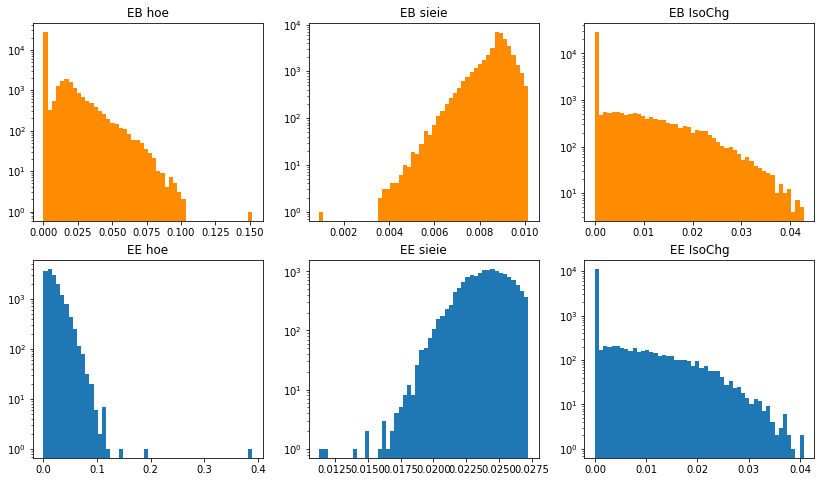

In [14]:
make_hist(phoEE,phoEB) # Real medium ID photon cut

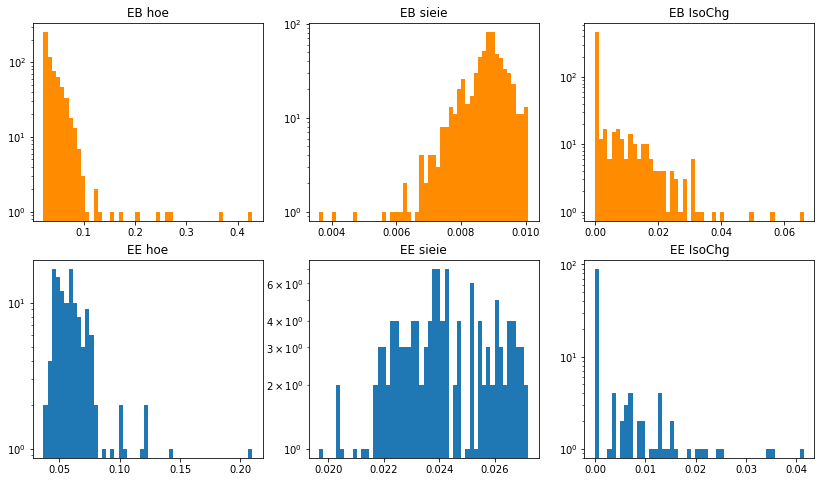

In [40]:
make_hist(phoEE,phoEB) # Real medium Isochg 0 0 

(0.0, 0.5)

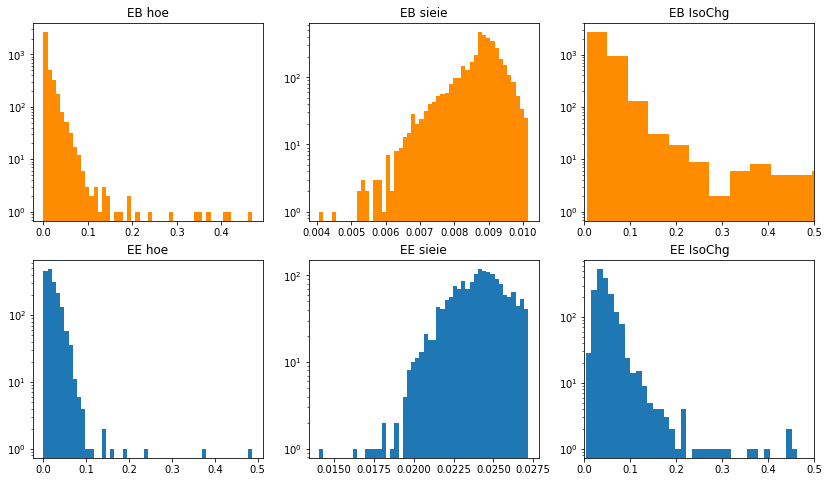

In [18]:
fig,axs = plt.subplots(2,3,figsize=(14,8))

axs[0,0].hist(flat_dim(phoEB.hoe),bins=50,color='darkorange')
axs[0,0].set_yscale('log')
axs[0,0].set_title('EB hoe')
axs[0,1].hist(flat_dim(phoEB.sieie),bins=50,color='darkorange')
axs[0,1].set_yscale('log')
axs[0,1].set_title('EB sieie')
axs[0,2].hist(flat_dim(phoEB.pfRelIso03_chg),bins=50,color='darkorange')
axs[0,2].set_yscale('log')
axs[0,2].set_title('EB IsoChg')
axs[0,2].set_xlim([0,0.5])

axs[1,0].hist(flat_dim(phoEE.hoe),bins=50)
axs[1,0].set_yscale('log')
axs[1,0].set_title('EE hoe')
axs[1,1].hist(flat_dim(phoEE.sieie),bins=50)
axs[1,1].set_yscale('log')
axs[1,1].set_title('EE sieie')
axs[1,2].hist(flat_dim(phoEE.pfRelIso03_chg),bins=50)
axs[1,2].set_yscale('log')
axs[1,2].set_title('EE IsoChg')
axs[1,2].set_xlim([0,0.5])

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
axs[0].hist(phoEE.pfRelIso03_chg)
#axs[0].set_yscale('log')
#axs[0].set_title('EE')

axs[1].hist(phoEB.pfRelIso03_chg)
#axs[1].set_yscale('log')
#axs[1].set_title('EB')

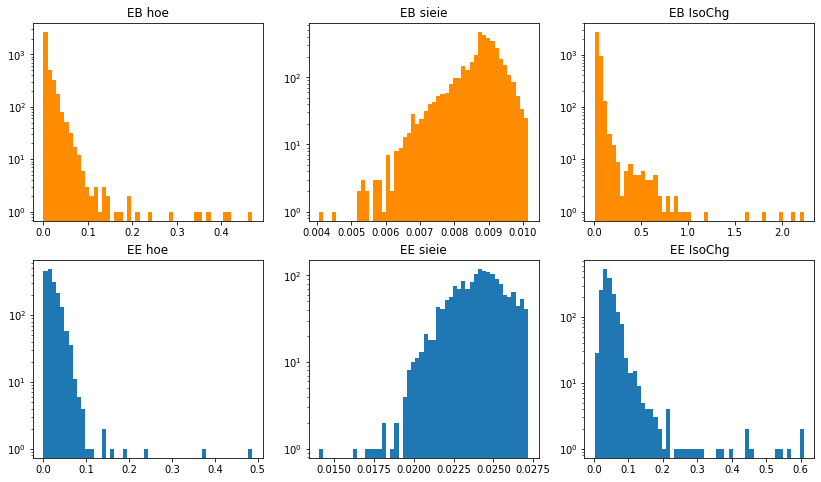

In [35]:
make_hist(phoEE,phoEB) # Photon medium without hoe 0 0

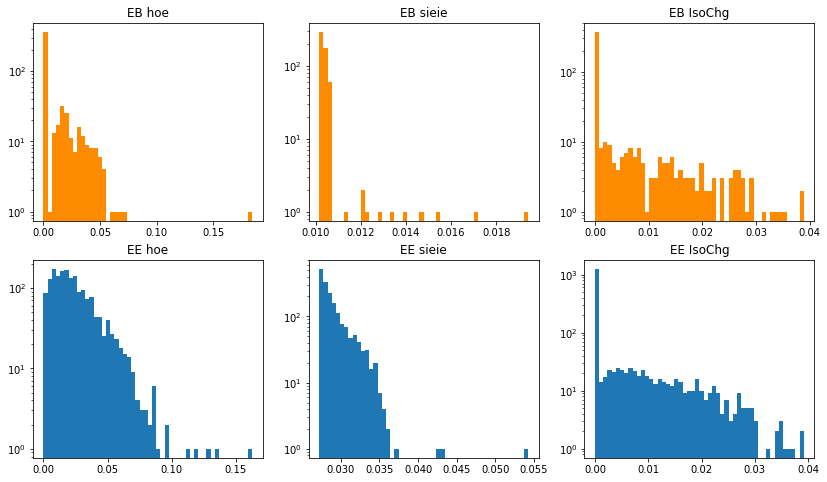

In [29]:
make_hist(phoEE,phoEB) # Photon medium  sieie 0 0 

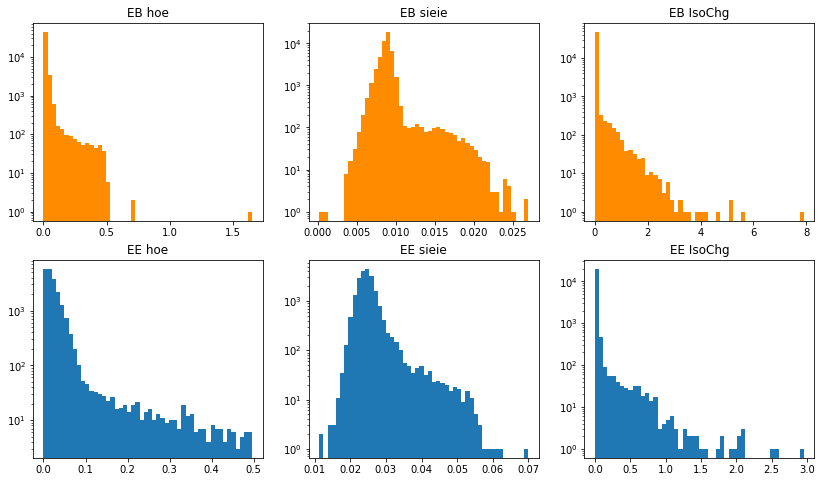

In [44]:
make_hist(phoEE,phoEB) # No Photon ID